# Анализ бизнес-показателей приложения
Несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Необходимо разобраться в причинах этой ситуации.

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

# Options for pandas
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 300

In [2]:
visits = pd.read_csv('visits_info.csv')
orders = pd.read_csv('orders_info.csv')
costs = pd.read_csv('costs_info.csv')

In [3]:
for df in [visits, orders, costs]:
    df.head()
    df.info()
    df.duplicated().sum()
    df.describe()
    print('')


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


0

,User Id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


0

,User Id,Revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


0

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


В таблицах нет пропусков, полных дубликатов, нет аномальных численных значений

Приведем столбцы к нижнему регистру и переименуем их для удобства

In [15]:
def col_rename(df):
    
    for col in df.columns:
        df = df.rename(columns = {col: col.lower().replace(' ', '_')})
        
        if col == 'session_start' or col == 'session_end':
            df = df.rename(columns = {'session_start': 'start', 'session_end': 'end'})
          
    return df

In [16]:
visits = col_rename(visits)
orders = col_rename(orders)
costs = col_rename(costs)

In [17]:
visits = col_rename(visits)
orders = col_rename(orders)
costs = col_rename(costs)

In [18]:
time_format = '%d.%m.%Y %H:%M'
visits['start'] = pd.to_datetime(visits['start'], format = time_format)
visits['end'] = pd.to_datetime(visits['end'], format = time_format)
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [19]:
visits.head()
orders.head()
costs.head()


,user_id,region,device,channel,start,end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00
2,590706206550,United States,Mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:00,2019-05-01 00:54:00
4,349773784594,United States,Mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Более детальная проверка на дубликаты

In [20]:
visits[visits[['user_id', 'start', 'end']].duplicated()]
orders[orders[['user_id', 'event_dt']].duplicated()]
costs[costs.duplicated()]


,user_id,region,device,channel,start,end


,user_id,event_dt,revenue


,dt,channel,costs


Дубликатов нет

## Исследовательский анализ данных

In [21]:
# Функция для составления пользовательского профиля
def get_profiles(sessions, orders, ad_costs):
    profiles = (
        sessions.sort_values(by=['user_id', 'start'])
        .groupby('user_id')
        .agg(
            {
                'start': 'first',
                'end': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .reset_index()
    )
    profiles['dt'] = profiles['start'].dt.date
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left'
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles




Профили пользователей с id, регионом, устройством, источником перехода, датой начала сессии

In [22]:
visits['dt'] = visits['start'].dt.date
orders['dt'] = orders['event_dt'].dt.date
costs['dt'] = costs['dt'].dt.date

profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,start,end,channel,device,region,dt,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,2019-05-07 21:11:00,FaceBoom,Mac,United States,2019-05-07,True,1.088172
1,4919697,2019-07-09 12:46:00,2019-07-09 14:44:00,FaceBoom,iPhone,United States,2019-07-09,False,1.107237
2,6085896,2019-10-01 09:58:00,2019-10-01 12:30:00,organic,iPhone,France,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,2019-08-22 21:52:00,AdNonSense,PC,Germany,2019-08-22,False,0.988235
4,31989216,2019-10-02 00:07:00,2019-10-02 00:20:00,YRabbit,iPhone,United States,2019-10-02,False,0.230769


Минимальная и максимальная даты привлечения пользователей

In [23]:
dt_min = profiles['dt'].min() 
dt_max = profiles['dt'].max() 
print(f'min date: {dt_min}')
print(f'max date: {dt_max}')


min date: 2019-05-01
max date: 2019-10-27


In [24]:
profiles.query('payer == True').groupby('device').agg({'user_id' : 'nunique'}).sort_values('user_id', ascending = False)

,user_id
device,
iPhone,3382
Android,2050
Mac,1912
PC,1537


In [25]:
def grouped(strr):
    plt.figure(figsize = (14, 6))
    profiles.groupby(strr).agg({'user_id' : 'nunique'}).sort_values('user_id', ascending = False)\
        .plot(kind = 'bar', ax = plt.subplot(1, 2, 1))
    plt.title('Распределение всех пользователей по {}'.format(strr))
    plt.legend(['пользователи'])
    
    profiles.query('payer == True').groupby(strr).agg({'user_id' : 'nunique'}).\
        sort_values('user_id', ascending = False).plot(kind = 'bar', ax = plt.subplot(1, 2, 2))
    
    plt.title('Распределение платящих пользователей по {}'.format(strr))
    plt.legend(['пользователи'])
    plt.show();
    
    
    
    
    table = profiles.groupby(strr).agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})\
    .sort_values(('user_id', 'nunique'), ascending = False)

    table = table.rename(columns = {'nunique': 'total', 'sum': 'payers', 'mean': '% payers of total'})#.sort_values(by = ('user_id', 'total'),  ascending = False)
    table.loc[:, [('payer', '% payers of total')] ] = table['payer']['% payers of total'] * 100 #.apply(lambda x: x * 100)
    
    display(table)
   


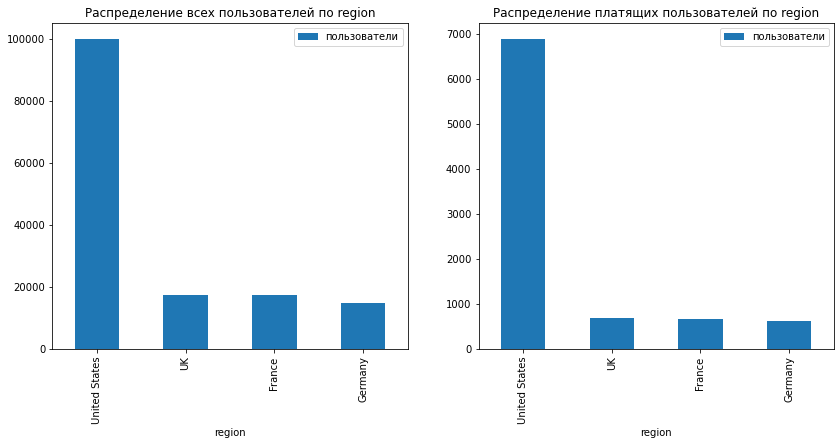

user_id  payer                  
                total payers % payers of total
region                                        
United States  100002   6902          6.901862
UK              17575    700          3.982930
France          17450    663          3.799427
Germany         14981    616          4.111875

In [26]:
grouped('region')

- Больше всего пользователей в США
- Больше всего платящих пользователей также в США

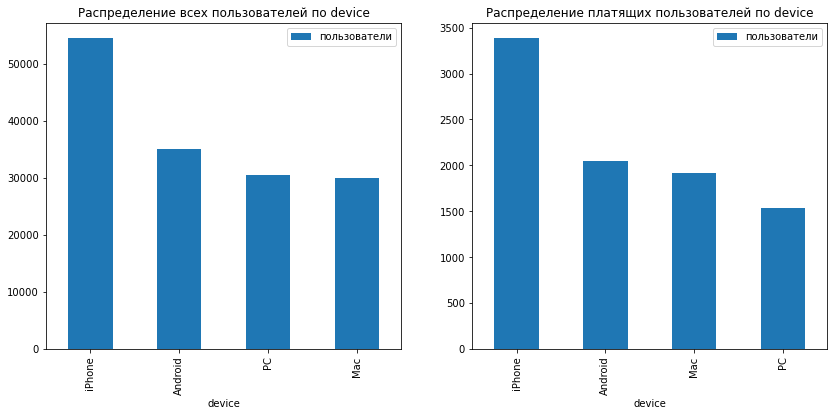

user_id  payer                  
          total payers % payers of total
device                                  
iPhone    54479   3382          6.207897
Android   35032   2050          5.851793
PC        30455   1537          5.046790
Mac       30042   1912          6.364423

In [27]:
grouped('device')

- Больше всего пользователей c iPhone
- Больше всего платящих пользователей также c iPhone

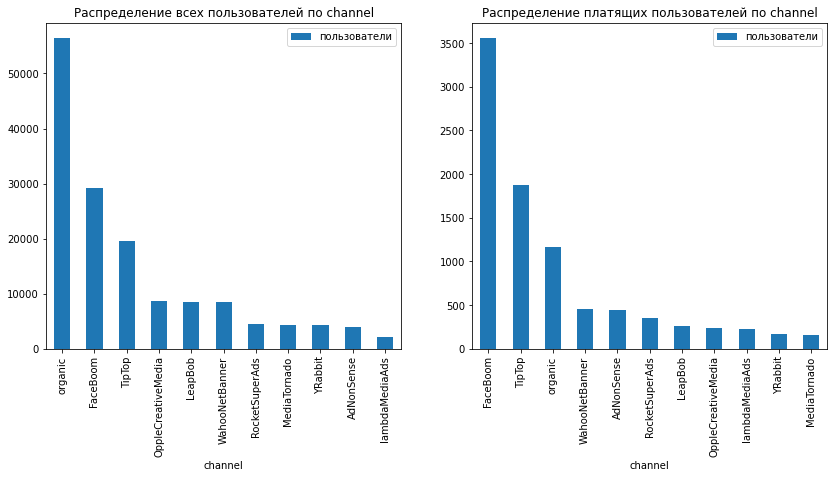

user_id  payer                  
                     total payers % payers of total
channel                                            
organic              56439   1160          2.055316
FaceBoom             29144   3557         12.204914
TipTop               19561   1878          9.600736
OppleCreativeMedia    8605    233          2.707728
LeapBob               8553    262          3.063253
WahooNetBanner        8553    453          5.296387
RocketSuperAds        4448    352          7.913669
MediaTornado          4364    156          3.574702
YRabbit               4312    165          3.826531
AdNonSense            3880    440         11.340206
lambdaMediaAds        2149    225         10.469986

In [28]:
grouped('channel')

- Больше всего пользователей без учета органических источников пришли из FaceBoom, TipTop и OppleCreativeMedia
- Больше всего платящих пользователей без учета органических источников пришли из FaceBoom, TipTop и WahooNetBanner

Промежуточные выводы: больше всего пользователей из США, самыми популярными устройствами являются iPhone и Android, пользователи в основном привлекаются из FaceBoom и TipTop. Для платящих пользователей результаты такие же

## Построение отчетов и подсчет метрик для продукта, продаж и маркетинга

### Продукт
-    Сколько людей пользуются в день, неделю, месяц?

In [29]:
profiles['dt'] = pd.to_datetime(profiles['dt'])
profiles['day'] = profiles['dt'].astype('datetime64[D]')
profiles['week'] = profiles['dt'].astype('datetime64[W]')
profiles['month'] = profiles['dt'].astype('datetime64[M]')
profiles.head()

,user_id,start,end,channel,device,region,dt,payer,acquisition_cost,day,week,month
0,599326,2019-05-07 20:58:00,2019-05-07 21:11:00,FaceBoom,Mac,United States,2019-05-07,True,1.088172,2019-05-07,2019-05-02,2019-05-01
1,4919697,2019-07-09 12:46:00,2019-07-09 14:44:00,FaceBoom,iPhone,United States,2019-07-09,False,1.107237,2019-07-09,2019-07-04,2019-07-01
2,6085896,2019-10-01 09:58:00,2019-10-01 12:30:00,organic,iPhone,France,2019-10-01,False,0.000000,2019-10-01,2019-09-26,2019-10-01
3,22593348,2019-08-22 21:35:00,2019-08-22 21:52:00,AdNonSense,PC,Germany,2019-08-22,False,0.988235,2019-08-22,2019-08-22,2019-08-01
4,31989216,2019-10-02 00:07:00,2019-10-02 00:20:00,YRabbit,iPhone,United States,2019-10-02,False,0.230769,2019-10-02,2019-09-26,2019-10-01


In [30]:
def au(strr, i):
    au = profiles.groupby(strr).agg({'user_id' : 'nunique'})
    au_mean = au['user_id'].mean()
    au.plot(ax = plt.subplot(1, 3, i + 1))
    plt.legend(['пользователи'])
    
    if strr == 'day':
        plt.title('DAU')
    if strr == 'week':
        plt.title('WAU')
    if strr == 'month':
        plt.title('MAU')
        
    return au_mean
    


 DAU_mean: 833.3777777777777

 WAU_mean: 5555.851851851852

 MAU_mean: 25001.333333333332


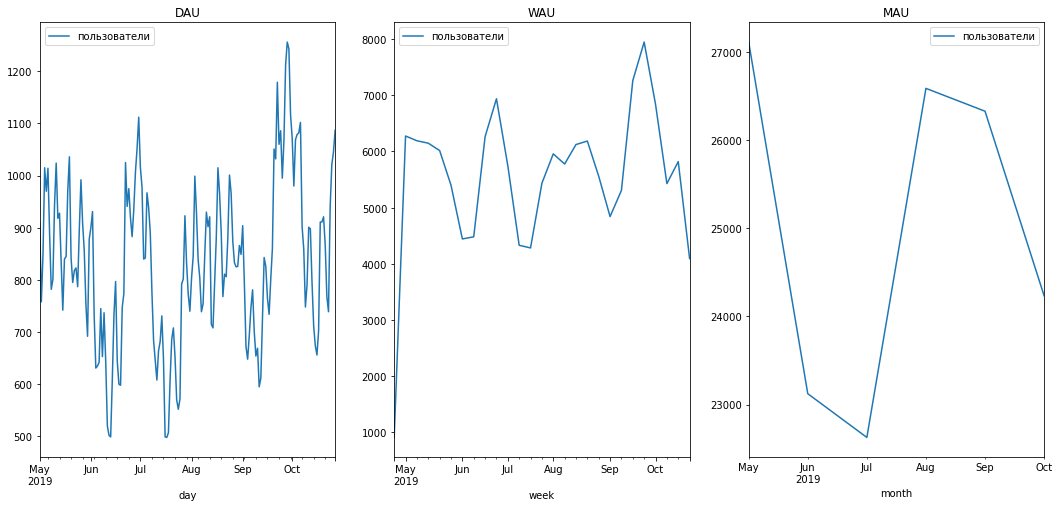

In [31]:
plt.figure(figsize = (18, 8))
for i, j in enumerate(['day', 'week', 'month']):   
    au_mean = au(j, i)
    print('\n', f'{j[0].upper()}AU_mean: {au_mean}')
    
plt.show();


-    Какое число пользовательских сессий?

Среднее количество сессий в день - 833.3777777777777


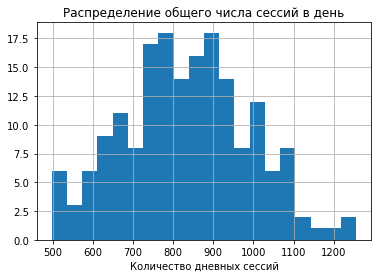

In [32]:
sessions = profiles.groupby(['day']).agg({'user_id': ['nunique', 'count']})

sessions['user_id']['count'].hist(bins = 20)
print(f'Среднее количество сессий в день - {sessions["user_id"]["count"].mean()}')
plt.title('Распределение общего числа сессий в день')
plt.xlabel('Количество дневных сессий')
plt.show();


-    Сколько длится одна сессия?

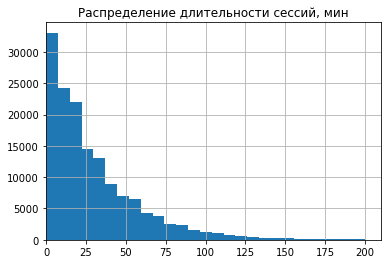

In [33]:
profiles['session_min'] = (profiles['end'] - profiles['start']).astype('timedelta64[m]')

profiles['session_min'].hist(bins = 50)
plt.title('Распределение длительности сессий, мин')
plt.xlim(0, 210)
plt.show();

In [34]:
profiles['session_min'].describe().to_frame()


,session_min
count,150008.000000
mean,30.030965
std,30.065484
min,0.000000
25%,9.000000
50%,21.000000
75%,42.000000
max,371.000000


В среднем сессия длится 30 минут

### Продажи

- Когда люди начинают покупать?

In [35]:
orders['dt'] = pd.to_datetime(orders['dt'])
profiles = profiles.merge(orders, on = ['user_id', 'dt'], how = 'left')

In [36]:
# неправильные значения event_dt
incorr = profiles[(profiles['event_dt'] - profiles['start']).astype('timedelta64[s]') < 0].index 
profiles = profiles.drop(incorr)


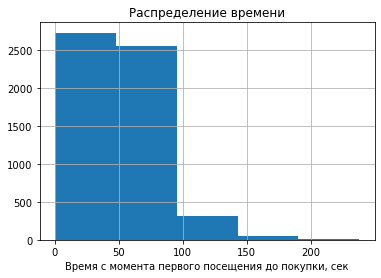

In [37]:
profiles['event_sec'] = (profiles['event_dt'] - profiles['start']).astype('timedelta64[s]')

first_buy = profiles.sort_values(['user_id', 'start', 'event_dt'])\
    .groupby('user_id').agg({'start': 'first', 'event_dt': 'first', 'event_sec': 'first'})\
    .dropna().reset_index()


first_buy['event_sec'].hist(bins = 5)

plt.title('Распределение времени')
plt.xlabel('Время с момента первого посещения до покупки, сек')

plt.show();

In [38]:
first_buy['event_sec'].describe(percentiles = [.25, .5, .94]).to_frame()


,event_sec
count,5667.000000
mean,51.044115
std,28.545345
min,0.000000
25%,31.000000
50%,49.000000
94%,97.000000
max,238.000000


Среднее и медианное значения примерно равны 50 секундам, т.е. с момента первого посещения до покупки проходит около 50 секунд. Также 94% пользователей совершили покупку менее, чем за 100 секунд

- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?

In [39]:
visits['dt'] = visits['start'].dt.date
orders['dt'] = orders['event_dt'].dt.date

profiles2 = visits.merge(orders, on = ['user_id', 'dt'], how = 'left')

profiles2['payer'] = profiles2['revenue'].apply(lambda x: True if x > 0 else False)

profiles2['dt'] = pd.to_datetime(profiles2['dt'])
profiles2['day'] = profiles2['dt'].astype('datetime64[D]')
profiles2['week'] = profiles2['dt'].astype('datetime64[W]')
profiles2['month'] = profiles2['dt'].astype('datetime64[M]')

profiles2['session_min'] = (profiles2['end'] - profiles2['start']).astype('timedelta64[m]')

incorr = profiles2[(profiles2['event_dt'] - profiles2['start']).astype('timedelta64[s]') < 0].index 

profiles2 = profiles2.drop(incorr)

profiles2['event_sec'] = (profiles2['event_dt'] - profiles2['start']).astype('timedelta64[s]')

profiles2.head()

,user_id,region,device,channel,start,end,dt,event_dt,revenue,payer,day,week,month,session_min,event_sec
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00,2019-05-01,NaT,NaN,False,2019-05-01,2019-04-25,2019-05-01,9.0,NaN
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00,2019-05-01,NaT,NaN,False,2019-05-01,2019-04-25,2019-05-01,1.0,NaN
2,590706206550,United States,Mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00,2019-05-01,NaT,NaN,False,2019-05-01,2019-04-25,2019-05-01,83.0,NaN
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:00,2019-05-01 00:54:00,2019-05-01,NaT,NaN,False,2019-05-01,2019-04-25,2019-05-01,25.0,NaN
4,349773784594,United States,Mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00,2019-05-01,NaT,NaN,False,2019-05-01,2019-04-25,2019-05-01,24.0,NaN


In [40]:
def sales_avg(strr, j):
    avg_sales = profiles2.query('payer == True').groupby(strr).agg({'user_id': ['nunique', 'count']})

    avg_sales['ratio'] = avg_sales['user_id']['count'] / avg_sales['user_id']['nunique']

    avg_sales['ratio'].plot(ax = plt.subplot(1, 3, j+1), figsize = (15, 6))
    plt.title(f'Среднее количество покупок за {strr}')
    
    print(f'{strr}_sales_mean = {avg_sales["ratio"].mean()}')
    

day_sales_mean = 1.0
week_sales_mean = 1.3161367274711393
month_sales_mean = 2.2283723957863106


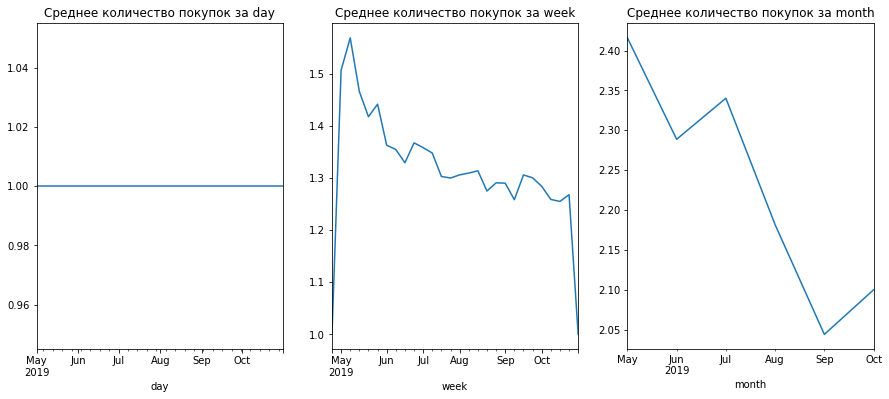

In [41]:
for i, j in enumerate(['day', 'week', 'month']):
    sales_avg(j, i)



В день в среднем совершается одна покупка, а динамика покупок за неделю и месяц с мая по ноябрь постоянно снижается 

- Какой средний чек за месяц, неделю, день?

In [42]:
def total_avg(strr, j):
    avg_total = profiles2.query('payer == True').groupby(strr).agg({'user_id': 'count', 'revenue': 'sum'})

    avg_total['ratio'] = avg_total['revenue'] / avg_total['user_id']
    if strr == 'day':
        avg_total['ratio'].rolling(7).mean().plot(ax = plt.subplot(1, 3, j+1), figsize = (15, 6))
        plt.title(f'Средний чек за {strr}, \n со скользящим средним с шириной окна 7')
    else:
        avg_total['ratio'].plot(ax = plt.subplot(1, 3, j+1), figsize = (15, 6)) 
        plt.title(f'Средний чек за {strr}')
    
    print(f'{strr}_total_mean = {avg_total["ratio"].mean()}')

day_total_mean = 5.375930515643058
week_total_mean = 5.3634742943626454
month_total_mean = 5.374214394630816


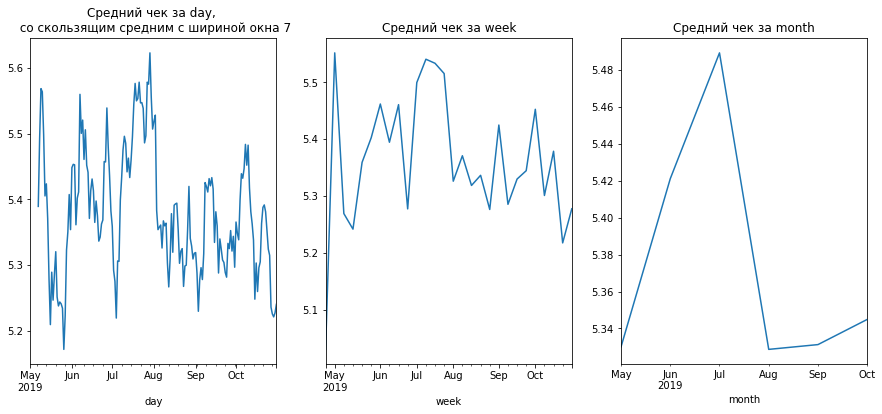

In [43]:
for i, j in enumerate(['day', 'week', 'month']):
    total_avg(j, i)

С мая по июль средний чек рос, затем начал снижаться

### Маркетинг

- Сколько денег потратили? Всего / на каждый источник / по времени

Общая сумма расходов на маркетинг: 105497


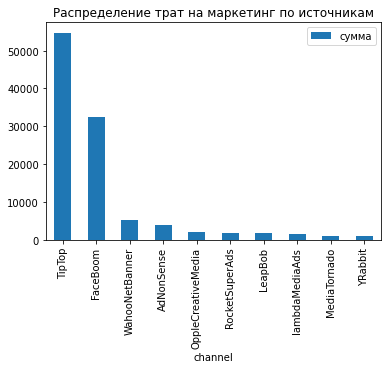

In [44]:
print(f'Общая сумма расходов на маркетинг: {int(costs["costs"].sum())}')
costs.groupby('channel')['costs'].sum().to_frame().sort_values('costs', ascending = False).plot(kind = 'bar')
plt.title('Распределение трат на маркетинг по источникам')
plt.legend(['сумма'])
plt.show();

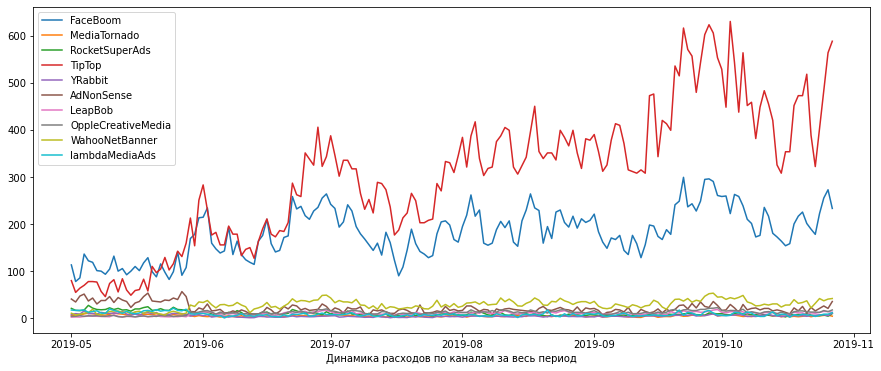

In [45]:
for i in costs['channel'].unique():
    avg = costs.query('channel == @i').groupby('dt').agg({'costs': 'mean'})
    avg['costs'].plot( figsize = (15, 6))
plt.legend(costs['channel'].unique())
plt.xlabel('Динамика расходов по каналам за весь период')
plt.show();

На графике видно, что для TipTop и FaceBoom траты постоянно увеличивались, а для других источников - оставались примерно на одном и том же уровне

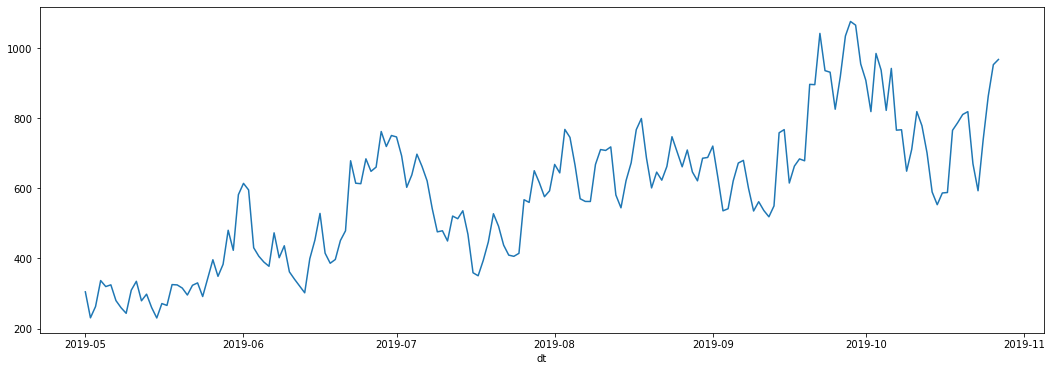

In [46]:
costs.groupby(['dt'])['costs'].sum().plot(figsize = (18, 6))
plt.show();

Общие траты увеличивались с каждым месяцем

- Сколько в среднем стоило привлечение одного пользователя из каждого источника?

In [47]:
print(f"CAC в среднем на одного пользователя для всего проекта: \
{profiles['acquisition_cost'].mean()}")


CAC в среднем на одного пользователя для всего проекта: 0.7032778251827625


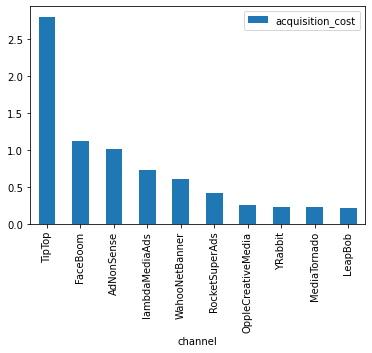

In [48]:
profiles.query('channel != "organic"').groupby('channel').agg({'acquisition_cost': 'mean'})\
.reset_index().sort_values('acquisition_cost', ascending = False)\
.plot(kind = 'bar', x = 'channel', y = 'acquisition_cost')
plt.show();

Самый высокий средний CAC на одного пользователя через источник TipTop - более 2.5

- в среднем показатели DAU, WAU, MAU росли с мая по ноябрь
- в среднем сессия длится 30 минут
- в среднем с момента первого посещения до покупки проходит 51 секунда
- динамика покупок за неделю и месяц с мая по ноябрь постоянно снижается
- средний чек за день, неделю, месяц не превышает 5,5
- больше всего рекламных денег были потрачены на TipTop и FaceBoom
- у TipTop и FaceBoom самый высокий средний CAC на одного пользователя
- траты на рекламу увеличивались с каждым месяцем

## Функции для расчета и анализа LTV, ROI, удержания и конверсии


### get_retention

In [49]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date').rename(columns={'start': 'first_ts'})

    result_raw = result_raw.merge(
        sessions[['user_id', 'start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['start'] - result_raw['first_ts']
    ).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
                
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

### get_conversion

In [50]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['start']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time


### get_ltv

In [51]:
def get_ltv(
    profiles,  
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('start <= @last_suitable_acquisition_date')


    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']],
        on= 'user_id',
        how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['start']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):

        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  
            aggfunc='sum',
        )

        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
    
        
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi
    
    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time, # таблица динамики ROI
    )

### plot_retention

In [52]:
def plot_retention(retention, retention_history, horizon):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'    
        retention = retention.reset_index().set_index(['cohort', 'payer'])
        
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()

    plt.show()



### plot_conversion

In [53]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


### plot_ltv_roi

In [54]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df


In [55]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


## Оценка окупаемости рекламы для привлечения пользователей


### Общая окупаемость рекламы

In [56]:
events = None
users = get_profiles(visits, orders, costs)
users

,user_id,start,end,channel,device,region,dt,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,2019-05-07 21:11:00,FaceBoom,Mac,United States,2019-05-07,True,1.088172
1,4919697,2019-07-09 12:46:00,2019-07-09 14:44:00,FaceBoom,iPhone,United States,2019-07-09,False,1.107237
2,6085896,2019-10-01 09:58:00,2019-10-01 12:30:00,organic,iPhone,France,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,2019-08-22 21:52:00,AdNonSense,PC,Germany,2019-08-22,False,0.988235
4,31989216,2019-10-02 00:07:00,2019-10-02 00:20:00,YRabbit,iPhone,United States,2019-10-02,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:00,2019-09-28 08:42:00,TipTop,iPhone,United States,2019-09-28,False,3.500000
150004,999975439887,2019-10-21 00:35:00,2019-10-21 01:05:00,organic,PC,UK,2019-10-21,False,0.000000
150005,999976332130,2019-07-23 02:57:00,2019-07-23 03:33:00,TipTop,iPhone,United States,2019-07-23,False,2.600000
150006,999979924135,2019-09-28 21:28:00,2019-09-28 21:46:00,MediaTornado,PC,United States,2019-09-28,False,0.205714


Стоит исключить всех пользователей, которые пришли из органических источников, так как на них не тратились деньги

In [57]:
users = users.query('channel != "organic"')

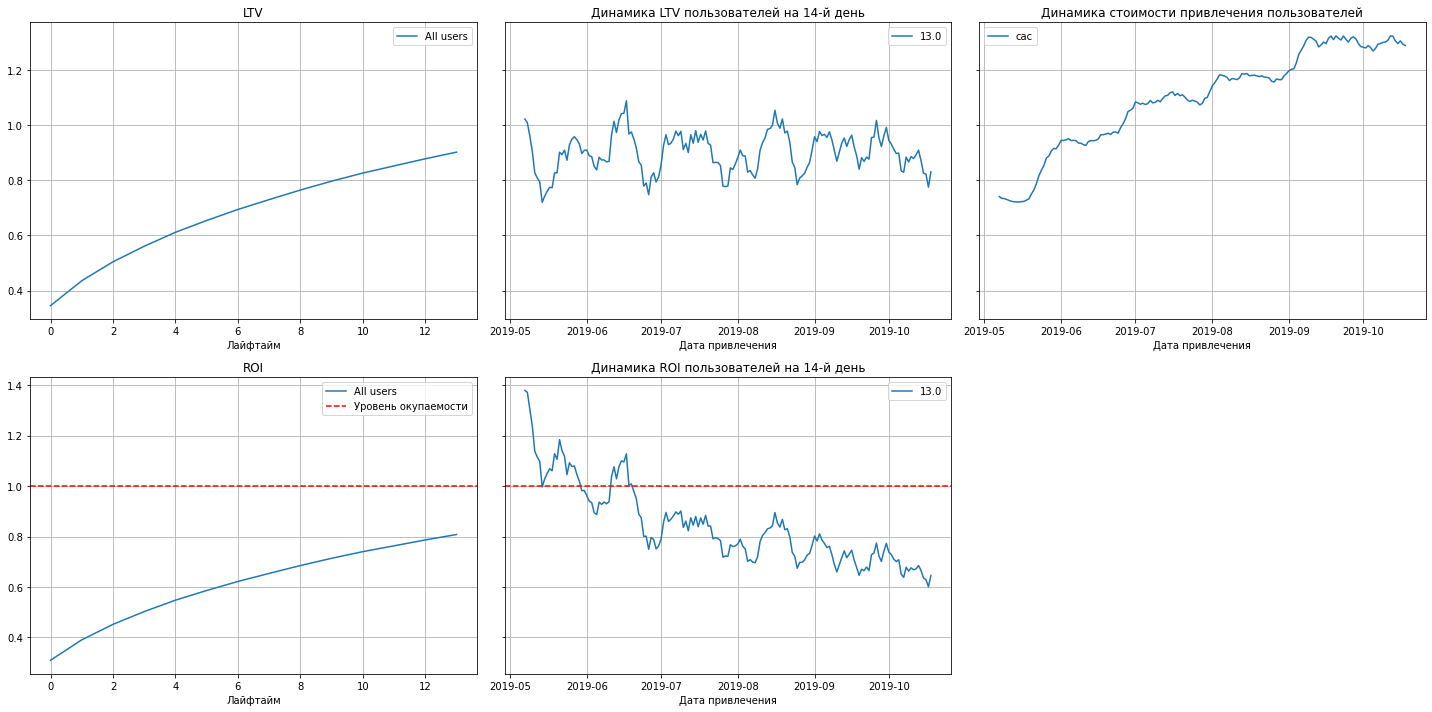

In [58]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users, 
    orders, 
    datetime(2019, 11, 1).date(), 
    14, 
    dimensions=[],
    ignore_horizon=False
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

- ROI ниже уровня окупаемости
- Динамика ROI на 14 день снижается каждый месяц, в конце ниже уровня окупаемости
- Динамика LTV находится в диапазоне 0.8 - 1 
- CAC увеличивался с каждым месяцем

### Окупаемость рекламы с разбивкой по устройствам

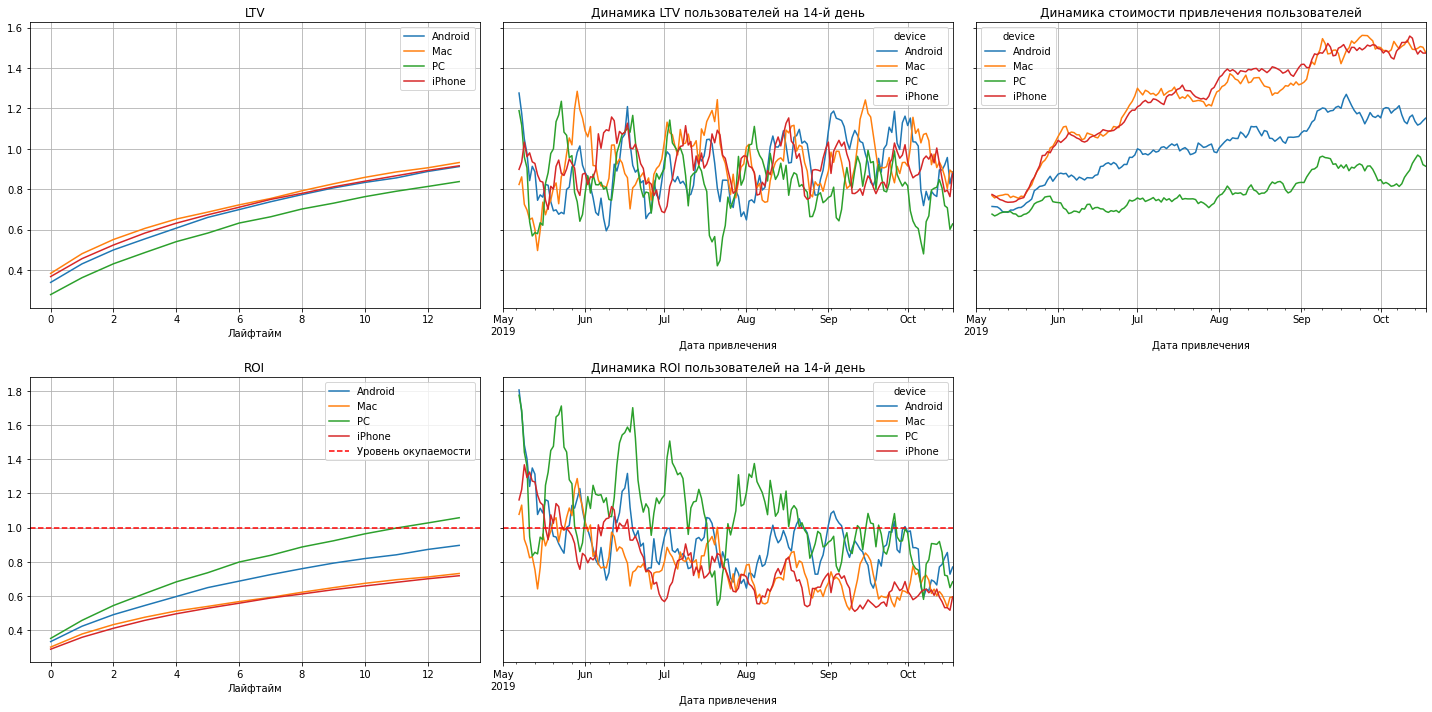

In [59]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users, 
    orders, 
    datetime(2019, 11, 1).date(), 
    14, 
    dimensions=['device'],
    ignore_horizon=False
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

- Только пользователи ПК окупились к 14 дню по ROI
- Динамика ROI на 14 день для всех устройств снижается каждый месяц, в конце ниже уровня окупаемости
- Динамика LTV находится в диапазоне 0.6 - 1.2 
- CAC увеличивался с каждым месяцем для всех устройств, лучший показатель - у ПК

### Окупаемость рекламы с разбивкой по странам

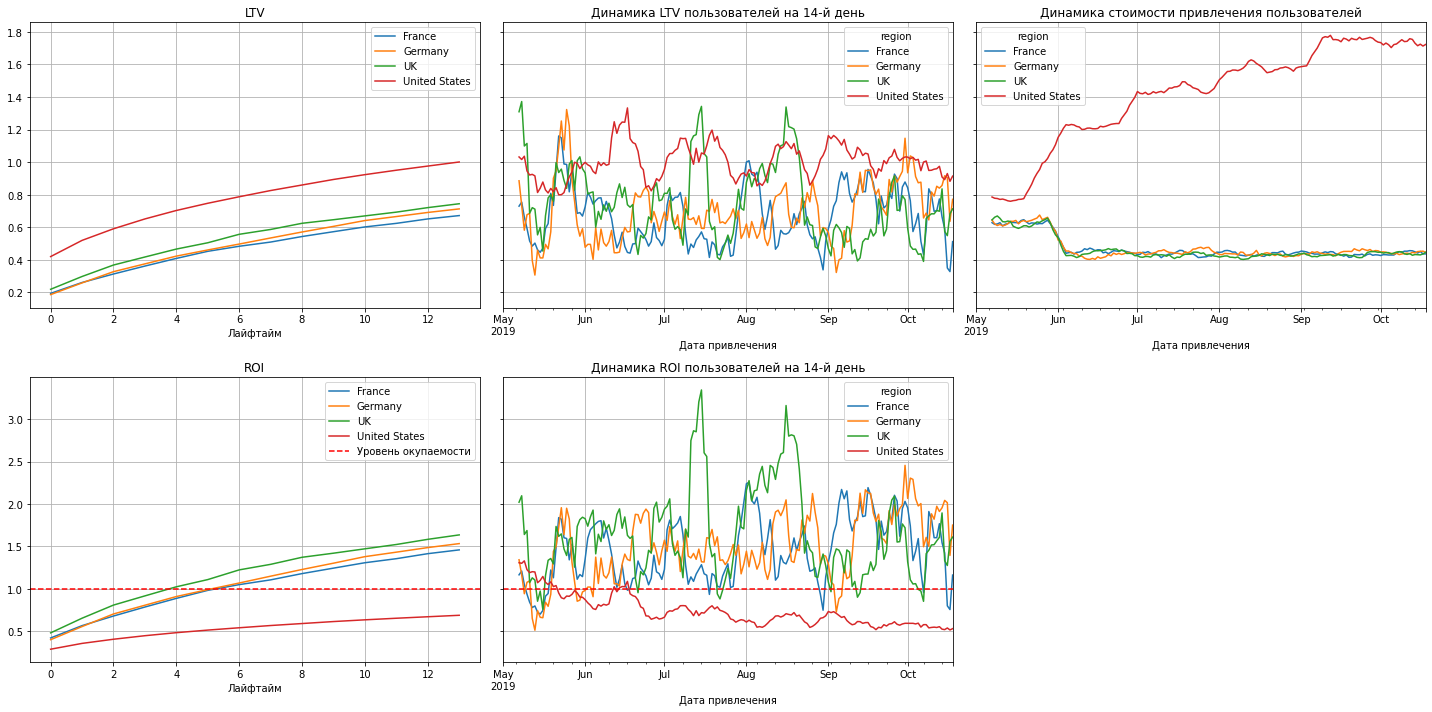

In [60]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users, 
    orders, 
    datetime(2019, 11, 1).date(), 
    14, 
    dimensions=['region'],
    ignore_horizon=False
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

- Только пользователи из США не окупились к 14 дню по ROI
- Динамика ROI на 14 день для всех стран выше уровня окупаемости, кроме пользователей из США
- Динамика LTV находится в диапазоне 0.4 - 1.4, самый высокий показатель - у США
- CAC увеличивался с каждым месяцем для пользователей из США, а для других стран снижался

### Окупаемость рекламы с разбивкой по рекламным каналам

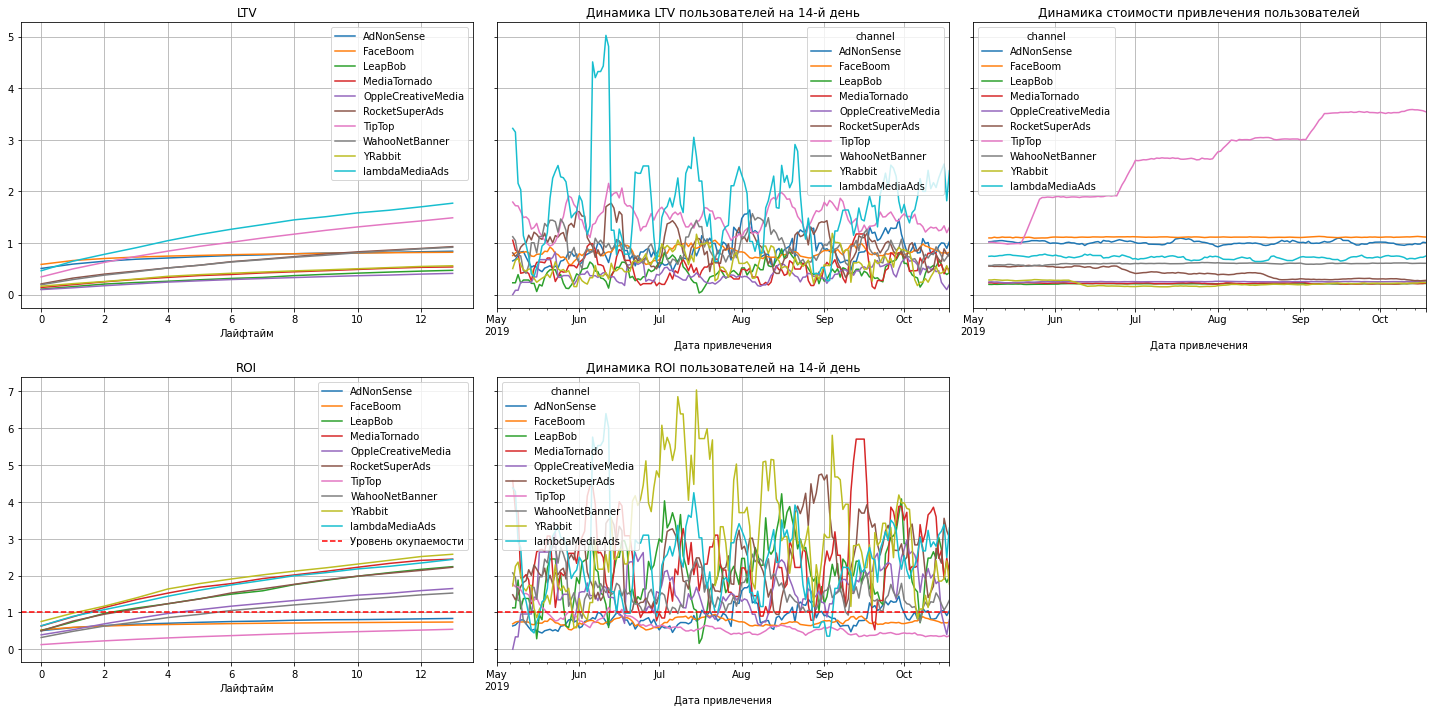

In [61]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users, 
    orders, 
    datetime(2019, 11, 1).date(), 
    14, 
    dimensions=['channel'],
    ignore_horizon=False
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

- Только пользователи, привлеченные из AdNonSense, Faceboom и TipTop не окупились к 14 дню по ROI
- Динамика ROI на 14 день для всех источников выше уровня окупаемости, кроме Faceboom и TipTop
- Динамика LTV находится в диапазоне 0 - 3, самый высокий показатель -  lambdaMediaAds
- CAC увеличивался с каждым месяцем только для источника TipTop, а для других источников оставался примерно на одном и том же уровне

### Графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

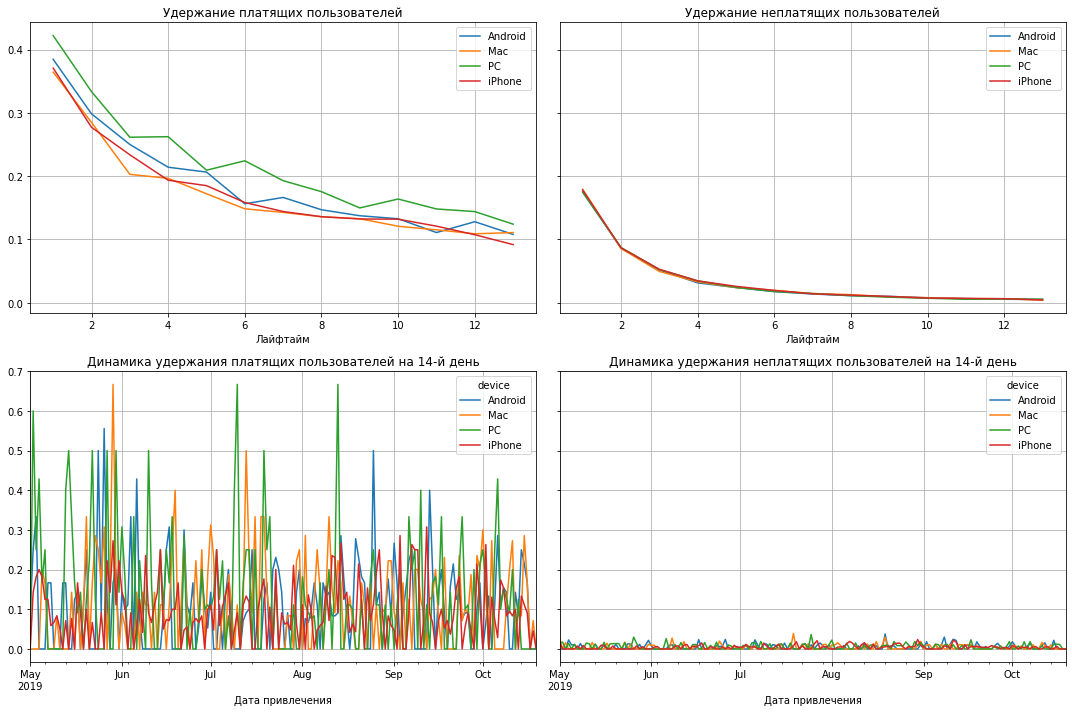

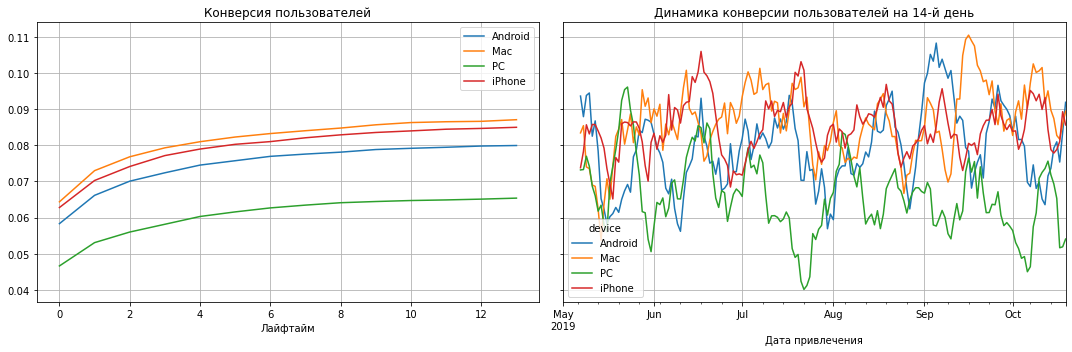

In [62]:
retention_raw, retention, retention_history = get_retention(
    users, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

conversion_raw, conversion, conversion_history = get_conversion(
    users, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

plot_retention(retention, retention_history, 14)

plot_conversion(conversion, conversion_history, 14)

- Среди платящих пользователй лучше всего удерживаются пользователи ПК
- Динамика удержания неплатящих пользователей на 14 день находится около 0
- Лучшая конверсия пользователей на Mac и iPhone
- Худшая динамика конверсии пользователей на 14 день у пользователей ПК

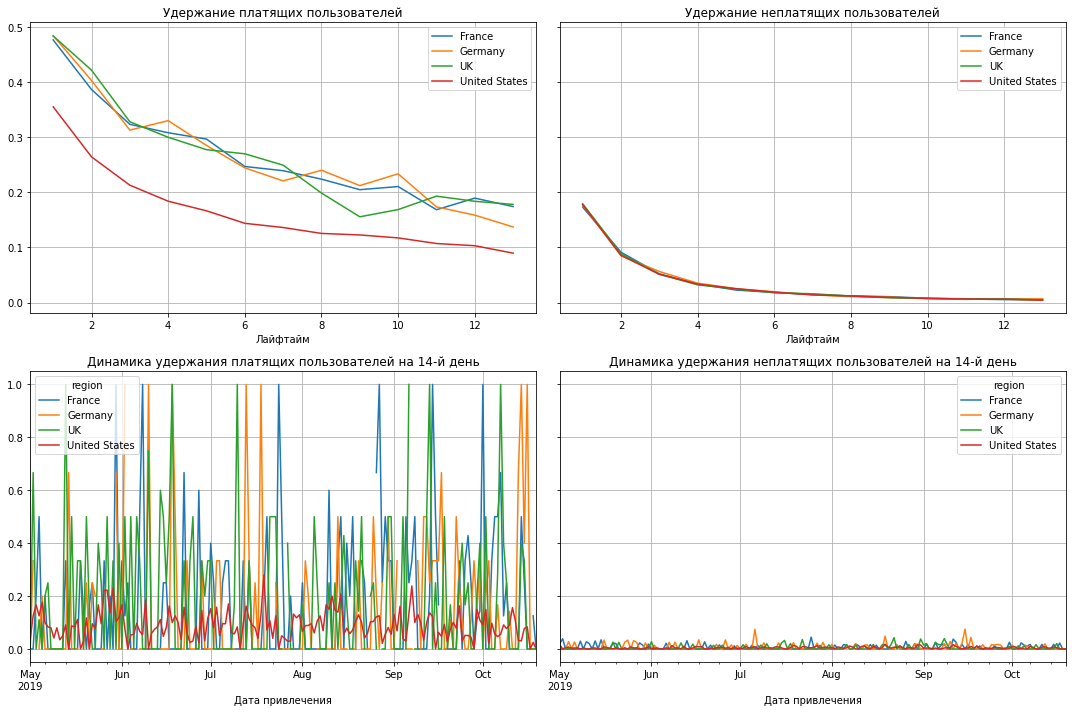

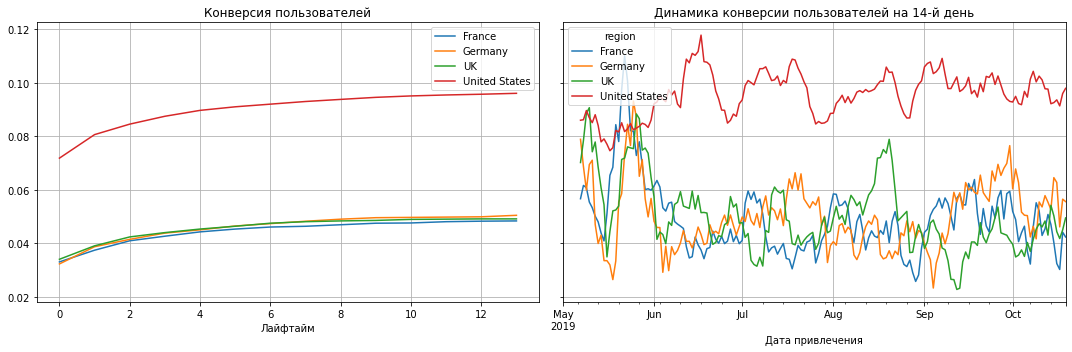

In [63]:
retention_raw, retention, retention_history = get_retention(
    users, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

conversion_raw, conversion, conversion_history = get_conversion(
    users, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

plot_retention(retention, retention_history, 14)

plot_conversion(conversion, conversion_history, 14)

- Среди платящих пользователй хуже всего удерживаются пользователи из США
- Динамика удержания платящих пользователей из США на 14 день не превышает 0.2
- Лучшая конверсия пользователей из США
- Лучшая динамика конверсии пользователей на 14 день у пользователей из США

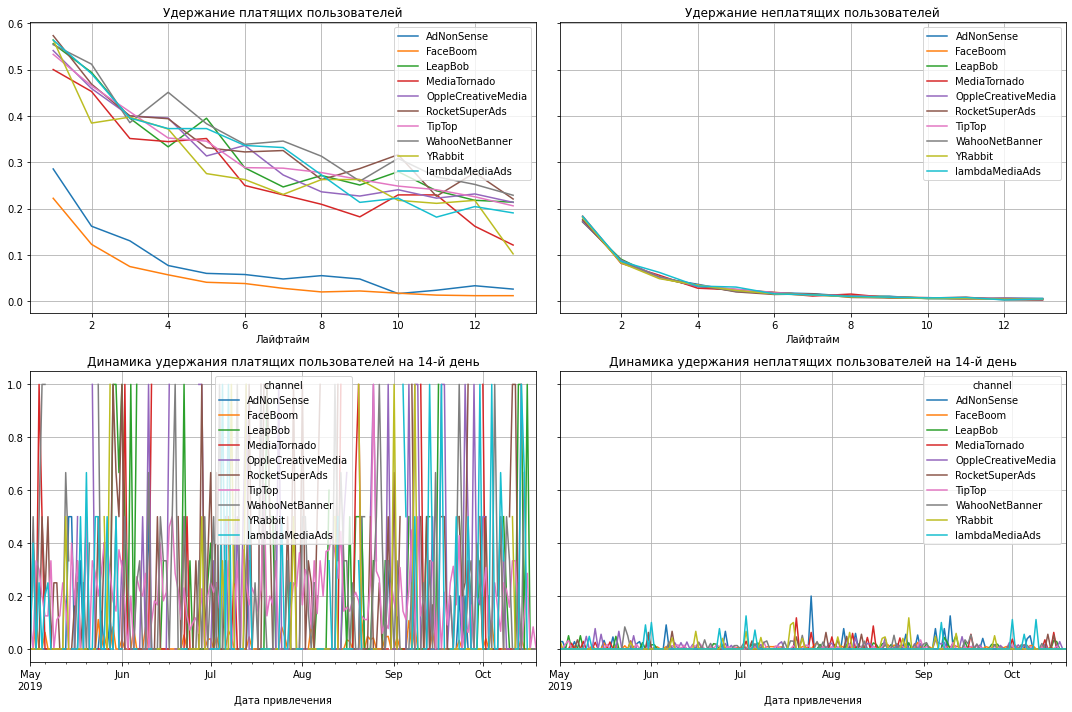

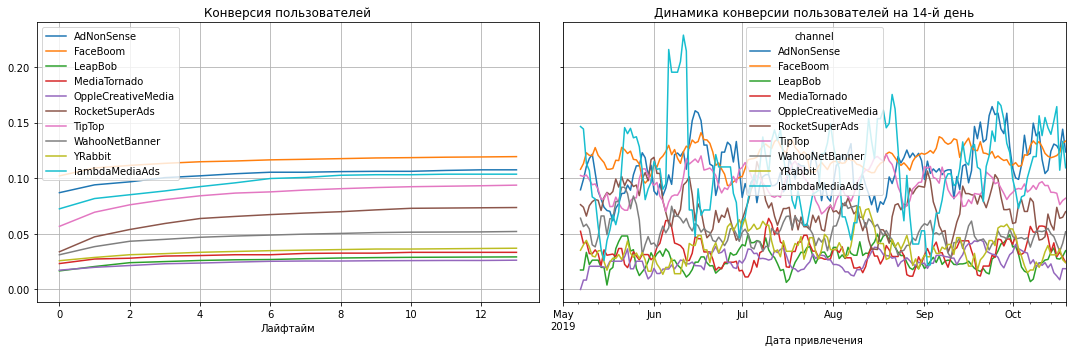

In [64]:
retention_raw, retention, retention_history = get_retention(
    users, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

conversion_raw, conversion, conversion_history = get_conversion(
    users, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

plot_retention(retention, retention_history, 14)

plot_conversion(conversion, conversion_history, 14)

- Среди платящих пользователй хуже всего удерживаются пользователи из AdNonSense и FaceBoom
- Лучшая конверсия пользователей из FaceBoom и AdNonSense
- Лучшая динамика конверсии пользователей на 14 день у пользователей из FaceBoom, AdNonSense и lambdaMediaAds

- В целом реклама не окупается
- На снижение окупаемости влияют:
   - пользователи всех устройств, кроме ПК
   - пользователи из США
   - пользователи, привлеченные из AdNonSense, Faceboom и TipTop
- Проблемы окупаемости связаны с тем, что: 
   - у пользователей на всех устройствах, кроме ПК высокая конверсия, но низкое удержание и высокий уровень CAC
   - пользовователей из США больше всего, у них высокая конверсия, но низкое удержание и очень высокий CAC
   - пользователей, привлеченных через Faceboom и TipTop больше всего, но у TipTop очень высокий CAC, а у Faceboom низкое удержание

Рекомендации для рекламного отдела: стоит снизить траты на рекламу в Faceboom и TipTop, стараться привлекать больше пользователей с ПК и привлекать меньше пользователей из США

## Выводы


Причины неэффективности привлечения пользователей:
- очень много пользователей из США, мало из других стран
- У пользователей США очень высокий CAC и низкое удержание
- очень много тратится на рекламу в TipTop и FaceBoom
- у TipTop очень высокий CAC, а у Faceboom низкое удержание


Рекомендации для отдела маркетинга: 
- стараться привлекать больше польователей с ПК и снижать CAC для пользователей iPhone и Mac
- помимо США привлекать больше пользователей из других стран, у них выше удержание и ниже CAC
- стоит снизить траты на рекламу в Faceboom и TipTop, хотя у них высокая конверсия, но также высокий CAC и они не окупаются по ROI
- обратить внимание на lambdaMediaAds, так как у них высокие показатели LTV и ROI
